In [1]:
# link the paths
import os, sys
project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")

if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import random
from matplotlib.colors import ListedColormap

from src.dataset import load_partition, SICAPv2Dataset
from src.attention_unet import AttentionUNet
from src.transforms import get_val_transform
from src.train import get_device

In [ ]:
# link datasets

DATA_ROOT = os.path.join(project_root, "data", "SICAPv2")
IMAGES = os.path.join(DATA_ROOT, "images")
MASKS = os.path.join(DATA_ROOT, "masks")
TEST_XLSX = os.path.join(DATA_ROOT, "partition", "Test", "Test.xlsx")

CHECKPOINT = os.path.join(project_root, "experiments", "final", "best_model.pth")

# Set this according to model used in training
NUM_CLASSES=2

In [4]:
img_paths, mask_paths, labels = load_partition(TEST_XLSX, IMAGES, MASKS)
test_ds = SICAPv2Dataset(img_paths, mask_paths, labels, transform=get_val_transform())
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

print("Test samples:", len(test_ds))

Test samples: 2122


1380, 948, 522, 741, 1377,1011, 1517

In [ ]:
idx = 1432
# idx = random.randint(0, len(test_ds)-1)  

image_tensor, gt_mask = test_ds[idx]

img_path = test_ds.image_paths[idx]
mask_path = test_ds.mask_paths[idx]

print("Image path:", img_path)
print("Mask path :", mask_path)

device = get_device()

model = AttentionUNet(in_channels=3, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(CHECKPOINT, map_location=device))
model.to(device)
model.eval()

print(idx)

Image path: /Users/rkakooza/Desktop/sicapv2-gleason-segmentation/data/SICAPv2/images/18B0006170D_Block_Region_1_1_5_xini_17507_yini_87969.jpg
Mask path : /Users/rkakooza/Desktop/sicapv2-gleason-segmentation/data/SICAPv2/masks/18B0006170D_Block_Region_1_1_5_xini_17507_yini_87969.jpg
Using Apple Metal (MPS) GPU
1432


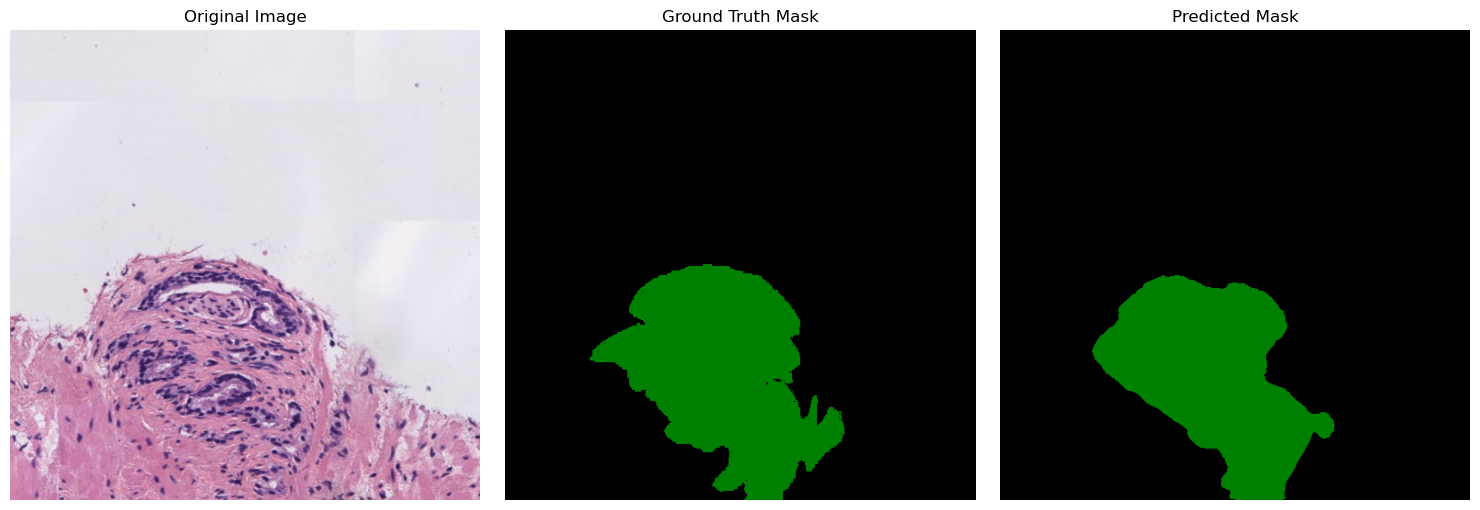

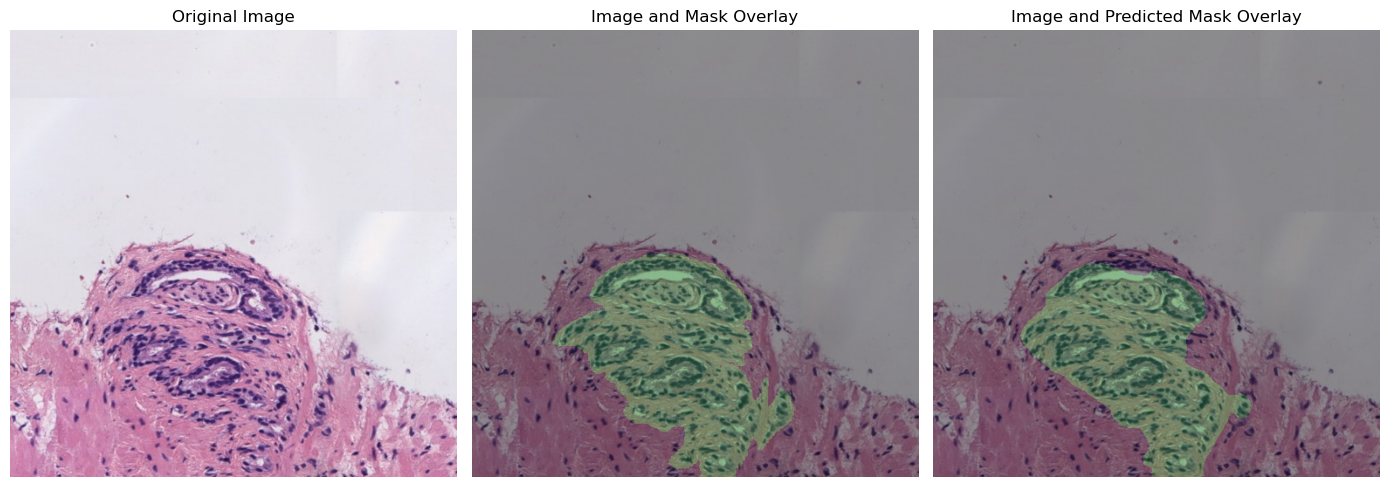

In [6]:
with torch.no_grad():
    input_tensor = image_tensor.unsqueeze(0).to(device)  
    logits = model(input_tensor)
    pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu()
    
image_np = image_tensor.permute(1, 2, 0).numpy()

gt_mask_np = gt_mask.numpy()
pred_mask_np = pred_mask.numpy()

# 0: background, 1: GG3, 2: GG4, 3: GG5
cmap = ListedColormap(["black", "green", "yellow", "red"])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_mask_np, cmap=cmap, vmin=0, vmax=3)
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask_np, cmap=cmap, vmin=0, vmax=3)
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

cmap = ListedColormap([
    "black",  # background
    "green"     # tissue
])

plt.figure(figsize=(14, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

# GT overlay
plt.subplot(1, 3, 2)
plt.imshow(image_np)
plt.imshow(gt_mask_np, cmap=cmap, alpha=0.4, vmin=0, vmax=1)
plt.title("Image and Mask Overlay")
plt.axis("off")

# Prediction overlay
plt.subplot(1, 3, 3)
plt.imshow(image_np)
plt.imshow(pred_mask_np, cmap=cmap, alpha=0.4, vmin=0, vmax=1)
plt.title("Image and Predicted Mask Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
print("GT mask class distribution:", np.unique(gt_mask_np, return_counts=True))
print("Pred mask class distribution:", np.unique(pred_mask_np, return_counts=True))

GT mask class distribution: (array([0, 1]), array([223240,  38904]))
Pred mask class distribution: (array([0, 1]), array([227415,  34729]))


In [ ]:
def gleason_to_isup(primary: int, secondary: int) -> int:
    """
    Convert Gleason primary + secondary patterns to ISUP Grade Group.
    """

    score = primary + secondary

    if score <= 6:
        return 1
    if score == 7 and primary == 3:
        return 2  # 3+4
    if score == 7 and primary == 4:
        return 3  # 4+3
    if score == 8:
        return 4
    if score >= 9:
        return 5

    return -1  # fallback

In [ ]:
import numpy as np
from typing import Dict, Optional

SICAPV2_LABELS = {
    0: "background",
    1: "benign",
    2: "gleason_3",
    3: "gleason_4",
    4: "gleason_5",
}

GLEASON_LABELS = [2, 3, 4]  # cancer-only classes


def extract_gleason_score(mask: np.ndarray) -> Dict:
    """
    Extract Gleason patterns and score from a SICAPv2 segmentation mask.

    Parameters
    ----------
    mask : np.ndarray
        2D segmentation mask with SICAPv2 labels.

    Returns
    -------
    dict with keys:
        - patterns_present
        - pattern_areas
        - primary_pattern
        - secondary_pattern
        - gleason_score
        - isup_grade_group
    """

    # Count pixels per Gleason class
    pattern_areas = {
        label: int(np.sum(mask == label))
        for label in GLEASON_LABELS
    }

    # Remove absent patterns
    pattern_areas = {
        label: area for label, area in pattern_areas.items() if area > 0
    }

    # No cancer present
    if len(pattern_areas) == 0:
        return {
            "patterns_present": [],
            "pattern_areas": {},
            "primary_pattern": None,
            "secondary_pattern": None,
            "gleason_score": None,
            "isup_grade_group": 0,  # benign
        }

    # Sort patterns by area (descending)
    sorted_patterns = sorted(
        pattern_areas.items(),
        key=lambda x: x[1],
        reverse=True
    )

    primary = sorted_patterns[0][0]
    secondary = sorted_patterns[1][0] if len(sorted_patterns) > 1 else primary

    gleason_score = f"{primary}+{secondary}"

    return {
        "patterns_present": [p for p, _ in sorted_patterns],
        "pattern_areas": pattern_areas,
        "primary_pattern": primary,
        "secondary_pattern": secondary,
        "gleason_score": gleason_score,
        "isup_grade_group": gleason_to_isup(primary, secondary),
    }

[0 1]


/var/folders/xj/d4yfsp6j44s6591wzrszs34w0000gn/T/ipykernel_91196/1786175348.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  mask = np.array(gt_mask)  # H x W
